# Simple Data Quality Control Example

Before using plant data in process models, quality control and fault detection analysis is recommended to identify potential data issues (i.e., missing or corrupt data) and data points that are not suitable for the intended analysis (i.e., abnormal plant behavior). This notebook demonstrates basic quality control analysis using a small data set. The analysis is run using [Pecos](https://pecos.readthedocs.io).

Pecos is an open-source Python package designed to monitor performance of time series data, subject to a series of quality control tests. The software includes methods to run quality control tests defined by the user and generate reports which include test results and graphics. The analysis also produces "clean data" which removes data points that failed quality control inspection.

## 1.  Read Data

For this example, the data is loaded from a csv file into a pandas DataFrame using the function `read_csv`. To use this data within Pecos, the data must have a timestamp index.  The index is converted to a timestamp using the `parse_dates` argument. 

The pandas `display.width` option is increased to 100 (the default value is 80) to make the quality control results easier to read in the Jupyter notebook.

In [1]:
import pandas as pd
pd.set_option('display.width', 100)

# Read plant data
data = pd.read_csv('simple_data.csv', index_col=0, parse_dates=True)
print(data)

                       A    B      C    D
2020-01-01 00:00:00  4.9  1.4   -4.5  2.0
2020-01-01 00:10:00  3.5 -4.5    0.1  2.3
2020-01-01 00:30:00  3.1  3.5    1.2  4.0
2020-01-01 00:40:00  3.0  5.0    3.5  4.8
2020-01-01 00:20:00  3.2  1.2 -999.0  2.5
2020-01-01 00:50:00  2.5 -5.6    5.2 -0.5
2020-01-01 01:00:00 -2.9  NaN    2.5  4.3
2020-01-01 01:10:00 -1.5  NaN    2.1  1.6
2020-01-01 01:20:00  0.0  2.5    0.2  3.5
2020-01-01 01:30:00 -6.5  3.9    1.5  2.9
2020-01-01 01:40:00 -7.2  4.0    4.1  4.8
2020-01-01 01:50:00 -4.3  4.2    4.4  4.6
2020-01-01 02:00:00 -1.8  4.9    3.3  0.9
2020-01-01 02:10:00 -3.6  1.2    3.7  0.7
2020-01-01 02:20:00 -2.5  2.8    2.2  2.2
2020-01-01 02:30:00 -2.9  0.4    1.3  2.6
2020-01-01 02:40:00 -3.2  2.0    2.8  3.4
2020-01-01 02:50:00 -4.5  2.4    1.6  4.0
2020-01-01 03:00:00 -2.1  1.6    2.2  3.8
2020-01-01 03:10:00 -3.0  0.4    2.5  2.6


## 2.  Run Quality Control Analysis

The Pecos `PerformanceMonitoring` class is used to run the analysis.  The first step is to create an instance of the PerformanceMonitoring object and populate that object with the time series data.

In [2]:
import pecos

pm = pecos.monitoring.PerformanceMonitoring()
pm.add_dataframe(data)

The following basic quality control tests can then be run:

* ``check_timestamp`` to see if data is monotonically increasing and sampled every 10 minutes (600 seconds)
* ``check_missing`` to identify missing data
* ``check_corrupt`` to identify corrupt data values of -999
* ``check_range`` to see if data is between -5 and 5
* ``check_outlier`` to see if data is within 3 standard deviations of the mean
* ``check_delta`` to identify data that changes by less than 1 within a 30 minute moving window (1800 seconds)

Pecos includes additional quality control tests. Users can also define custom quality control functions to be used in Pecos. 

In [3]:
pm.check_timestamp(frequency=600)
pm.check_missing()
pm.check_corrupt(corrupt_values=[-999])
pm.check_range(bound=[-5,5])
pm.check_outlier(bound=[-3,3])
pm.check_delta(bound=[1, None], window=1800)

One advantage of using Pecos is that the results from individual quality control tests are collected in a table that can be exported to a text file and included in reports (as shown in Step 3).  The results are stored in `pm.test_results`.  This DataFrame is updated each time a quality control test is run.  

In [4]:
print(pm.test_results)

  Variable Name          Start Time            End Time Timesteps                 Error Flag
0               2020-01-01 00:20:00 2020-01-01 00:20:00         1     Nonmonotonic timestamp
1             B 2020-01-01 01:00:00 2020-01-01 01:10:00         2               Missing data
2             C 2020-01-01 00:20:00 2020-01-01 00:20:00         1               Corrupt data
3             A 2020-01-01 01:30:00 2020-01-01 01:40:00         2     Data < lower bound, -5
4             B 2020-01-01 00:50:00 2020-01-01 00:50:00         1     Data < lower bound, -5
5             C 2020-01-01 00:50:00 2020-01-01 00:50:00         1      Data > upper bound, 5
6             C 2020-01-01 00:00:00 2020-01-01 00:00:00         1  Outlier < lower bound, -3
7             A 2020-01-01 00:10:00 2020-01-01 00:50:00         5     Delta < lower bound, 1


The quality control test results are also used to produce "clean data" which removes data points that failed quality 
control inspection (replaced by NaN).  The cleaned data is stored in `pm.cleaned_data` and is generated based on current test results. 
Data points that do not pass quality control inspection can be replaced by various means (interpolation, data from 
a duplicate sensor, values from a model) before using the data for further analysis.
Data replacement strategies are generally defined on a case-by-case basis. 
If large sections of the data failed quality control tests, the data might not be suitable for use.

In [6]:
print(pm.cleaned_data)

                       A    B    C    D
2020-01-01 00:00:00  4.9  1.4  NaN  2.0
2020-01-01 00:10:00  NaN -4.5  0.1  2.3
2020-01-01 00:20:00  NaN  1.2  NaN  2.5
2020-01-01 00:30:00  NaN  3.5  1.2  4.0
2020-01-01 00:40:00  NaN  5.0  3.5  4.8
2020-01-01 00:50:00  NaN  NaN  NaN -0.5
2020-01-01 01:00:00 -2.9  NaN  2.5  4.3
2020-01-01 01:10:00 -1.5  NaN  2.1  1.6
2020-01-01 01:20:00  0.0  2.5  0.2  3.5
2020-01-01 01:30:00  NaN  3.9  1.5  2.9
2020-01-01 01:40:00  NaN  4.0  4.1  4.8
2020-01-01 01:50:00 -4.3  4.2  4.4  4.6
2020-01-01 02:00:00 -1.8  4.9  3.3  0.9
2020-01-01 02:10:00 -3.6  1.2  3.7  0.7
2020-01-01 02:20:00 -2.5  2.8  2.2  2.2
2020-01-01 02:30:00 -2.9  0.4  1.3  2.6
2020-01-01 02:40:00 -3.2  2.0  2.8  3.4
2020-01-01 02:50:00 -4.5  2.4  1.6  4.0
2020-01-01 03:00:00 -2.1  1.6  2.2  3.8
2020-01-01 03:10:00 -3.0  0.4  2.5  2.6


A boolean mask, stored in `pm.mask`, indicates which data points passed quality control inspection. The mask can be used to compute a quality control index (QCI) which indicates the percent of data points that pass quality control tests. 

In [8]:
QCI = pecos.metrics.qci(mask=pm.mask)
print(QCI)

A    0.65
B    0.85
C    0.85
D    1.00
dtype: float64


## 3.  Generate a Report

Results can be included in HTML or LATEX formatted reports.  The ``plot_test_results`` function creates a graphic for each variable that includes a quality control test failure, highlighting data points that failed a test.
The ``write_monitoring_report`` generates an report (HTML format by default) that includes the test results summary, quality control index, and graphics. 
The following example creates a HTML report file in current working directory named `simple_report.html`.
The images are encoded into the HTML file using the `encode=True` option, the images can also be linked to image files.

In [9]:
test_results_graphics = pecos.graphics.plot_test_results(data=pm.data, test_results=pm.test_results)

filename = pecos.io.write_monitoring_report(data=pm.data, test_results=pm.test_results, metrics=QCI.to_frame('QCI'), 
                                            test_results_graphics=test_results_graphics, encode=True,
                                            filename='simple_report.html')

The HTML report file can be opened locally using an internet browser.  The following lines of code display the report within the Jupyter notebook.


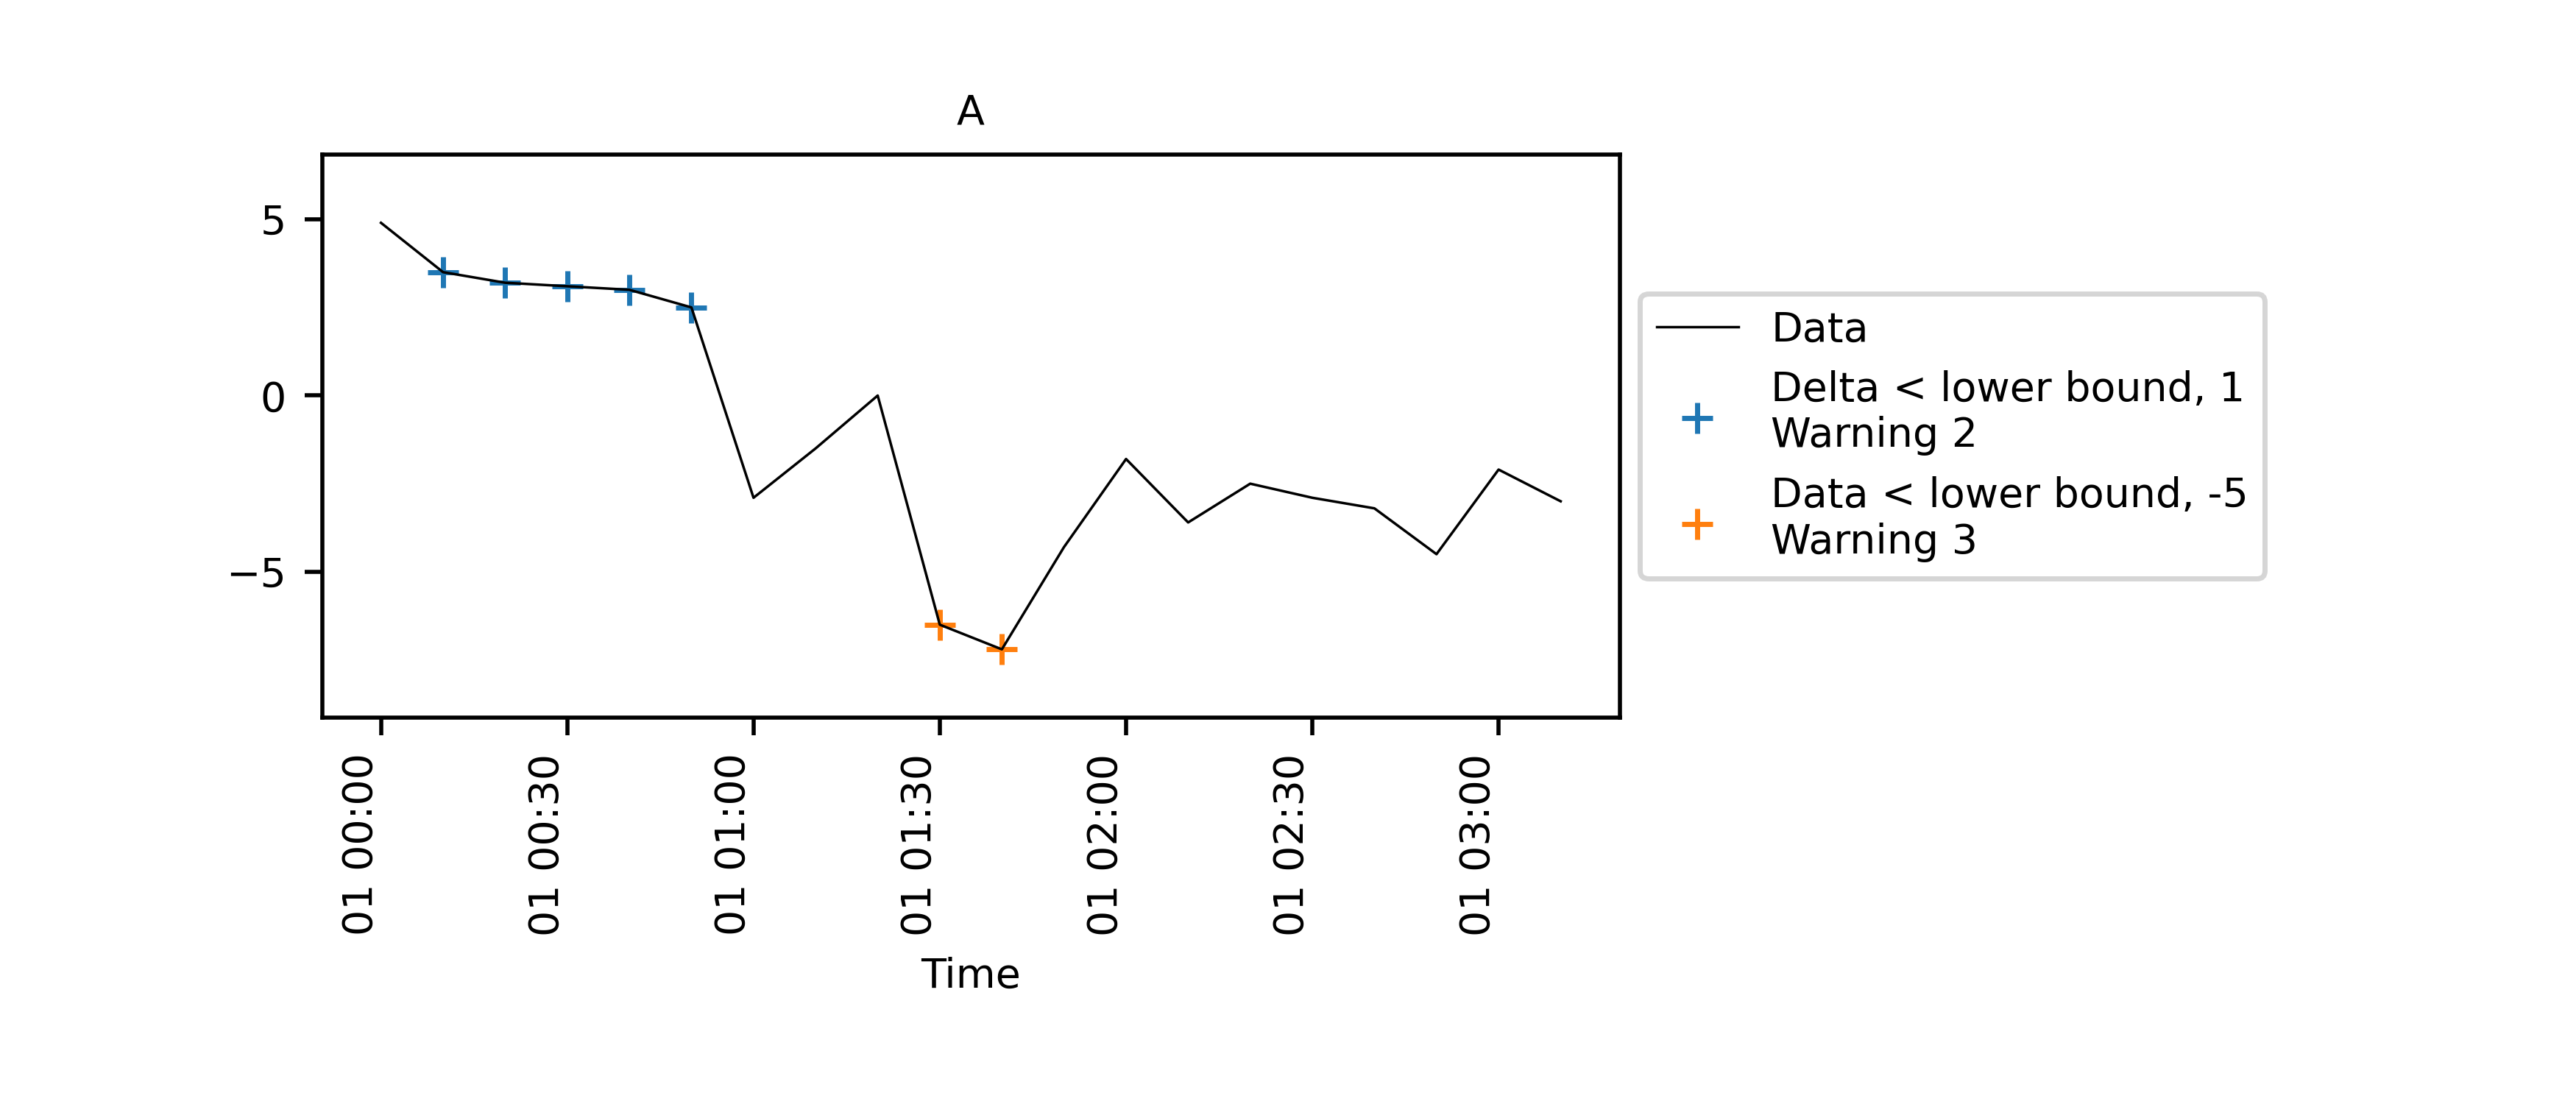
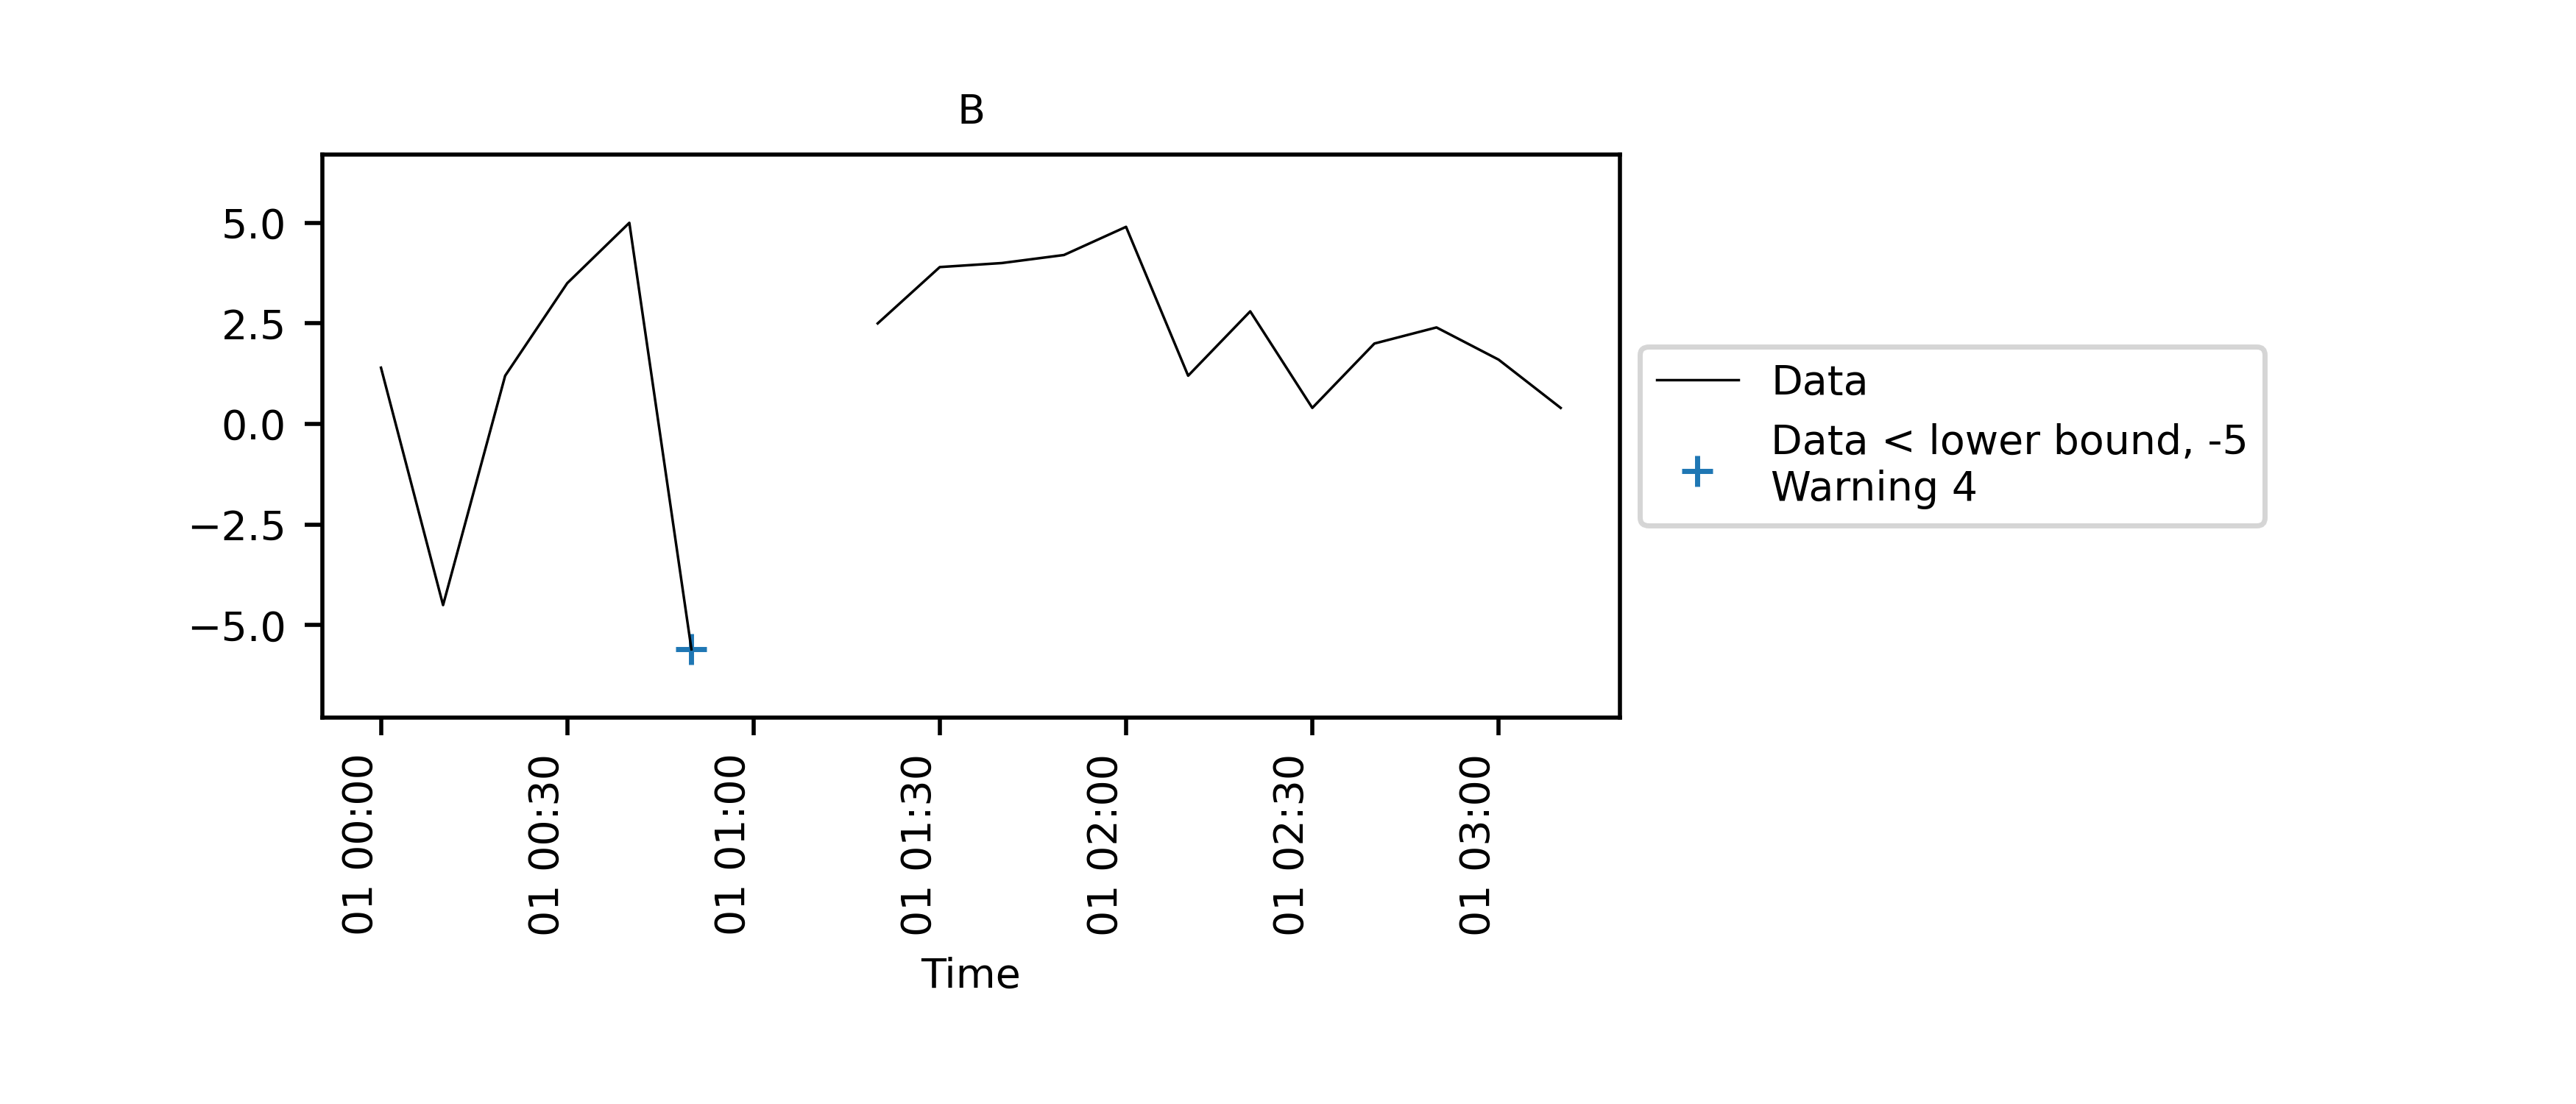
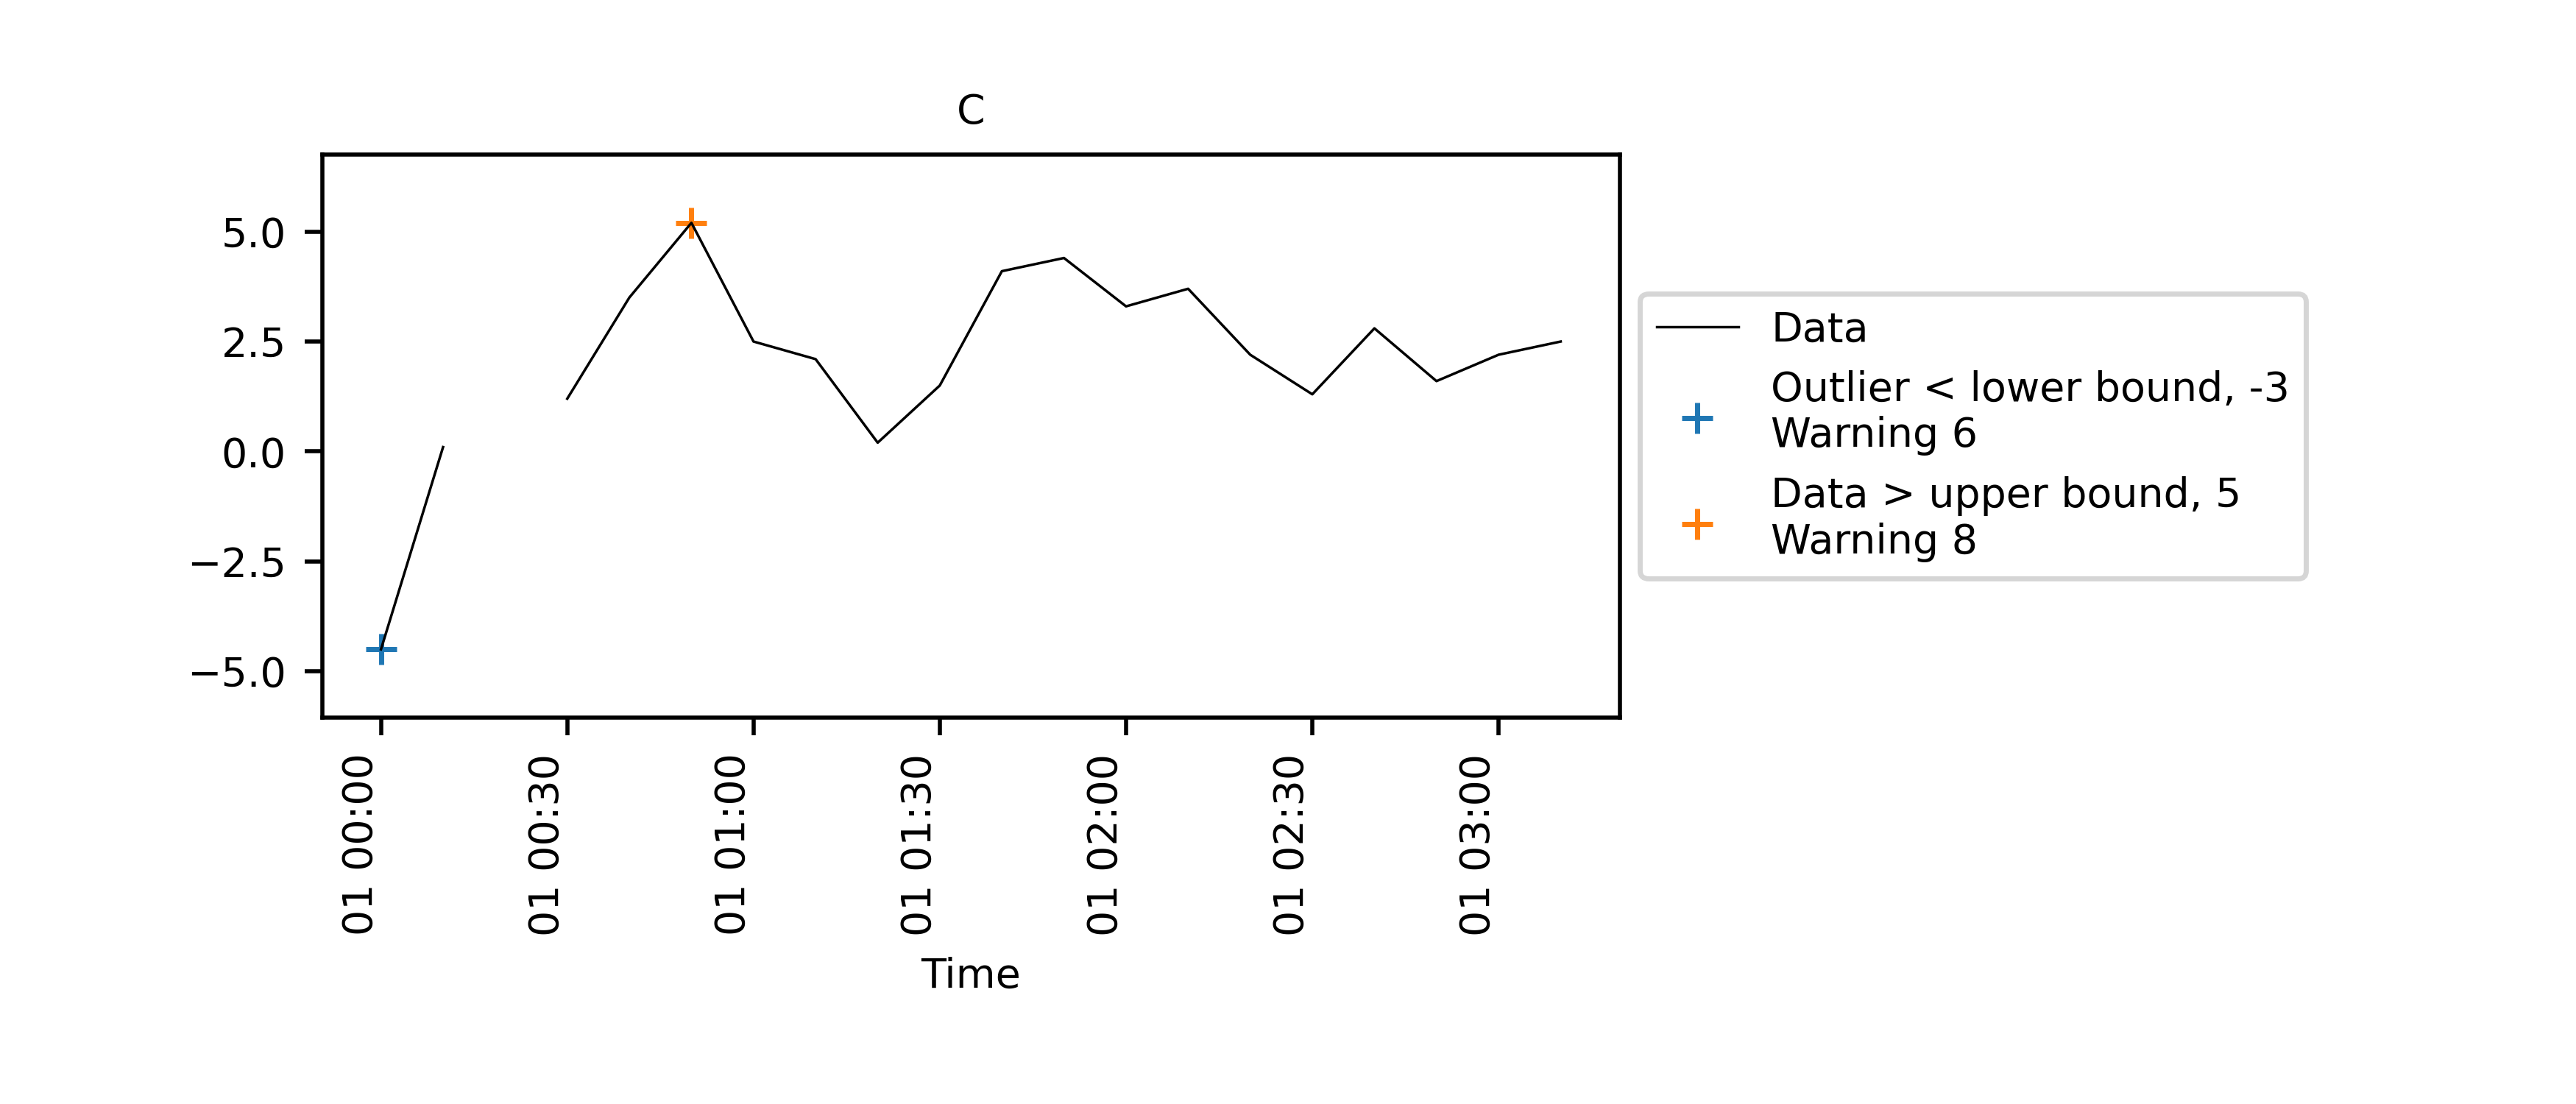

In [11]:
from IPython.core.display import HTML
HTML(filename=filename)